In [1]:
import psycopg
#import matplotlib as mp
import pandas as pd
import datetime as dt

# connect to psql database
conn = psycopg.connect(host="localhost", dbname="trader", user
                        ="jeffrey", password="strawberries")
conn.autocommit = True
cur = conn.cursor()

today = dt.datetime.today()                 # datetime.datetime object
yesterday = today - dt.timedelta(days=1)    # datetime.datetime object
data_date = today                           # datetime.datetime object


In [2]:

reqid_today_string = """
    CREATE OR REPLACE VIEW reqid_symbol_today AS
        SELECT
            send_time,
            reqid,
            symbol
        FROM
            reqid_list
        WHERE
            send_time::date = CURRENT_DATE;
"""

reqid_yesterday_string = """
    CREATE OR REPLACE VIEW reqid_symbol_yesterday AS
        SELECT
            send_time,
            reqid,
            symbol
        FROM
            reqid_list
        WHERE
            send_time::date = CURRENT_DATE - INTERVAL '1 day';
"""

spx_price_today_string = """
    CREATE OR REPLACE VIEW spx_price_today AS
    SELECT
        r.reqid,
        r.symbol,
        r.send_time,
        t.price,
        t.name,
        t.recv_time
    FROM
        reqid_symbol_today r
    JOIN
        tick_price t
    ON
        r.reqid = t.reqid
    WHERE
        r.symbol = 'SPX' AND t.recv_time::date = CURRENT_DATE AND t.name = 'LAST'
    ORDER BY t.recv_time ASC;
"""

spx_price_yesterday_string = """
    CREATE OR REPLACE VIEW spx_price_yesterday AS
    SELECT
        r.reqid,
        r.symbol,
        r.send_time,
        t.price,
        t.name,
        t.recv_time
    FROM
        reqid_symbol_yesterday r
    JOIN
        tick_price t
    ON
        r.reqid = t.reqid
    WHERE
        r.symbol = 'SPX' AND t.recv_time::date = CURRENT_DATE - INTERVAL '1 day' AND t.name = 'LAST'
    ORDER BY t.recv_time ASC;
"""

spx_price_all_today_string = """
    CREATE OR REPLACE VIEW spx_price_all_today AS
    SELECT
        r.reqid,
        r.symbol,
        r.send_time,
        t.price,
        t.name,
        t.recv_time
    FROM
        reqid_symbol_today r
    JOIN
        tick_price t
    ON
        r.reqid = t.reqid
    WHERE
        r.symbol = 'SPX' AND t.recv_time::date = CURRENT_DATE
    ORDER BY t.recv_time ASC;
"""

spx_price_all_yesterday_string = """
    CREATE OR REPLACE VIEW spx_price_all_yesterday AS
    SELECT
        r.reqid,
        r.symbol,
        r.send_time,
        t.price,
        t.name,
        t.recv_time
    FROM
        reqid_symbol_yesterday r
    JOIN
        tick_price t
    ON
        r.reqid = t.reqid
    WHERE
        r.symbol = 'SPX' AND t.recv_time::date = CURRENT_DATE - INTERVAL '1 day'
    ORDER BY t.recv_time ASC;
"""


# materialized view for spx_price_today
# spx_price_today_string = """
#     CREATE OR REPLACE VIEW spx_price_today_mv AS
#     SELECT
#         r.reqid,
#         r.symbol,
#         r.send_time,
#         t.price,
#         t.name,
#         t.recv_time
#     FROM
#         reqid_today r
#     JOIN
#         tick_price t
#     ON
#         r.reqid = t.reqid
#     WHERE
#         r.symbol = 'SPX' AND t.recv_time::date = CURRENT_DATE - INTERVAL '1 day' AND t.name = 'LAST';"""
#create_index_on_MV = """CREATE UNIQUE INDEX spx_price_today_mv_idx ON spx_price_today_mv (recv_time);"""




In [ ]:
cur.execute(reqid_today_string)
cur.execute(reqid_yesterday_string)
cur.execute(spx_price_today_string)
cur.execute(spx_price_yesterday_string)
cur.execute(spx_price_all_today_string)
cur.execute(spx_price_all_yesterday_string)

In [2]:
# find all days with "price" data in tick_price table
cur.execute("SELECT recv_time, price FROM spx_price_today;")
spx_data = cur.fetchall()


In [3]:
# Convert data to a pandas DataFrame
spx_df = pd.DataFrame(spx_data, columns=['recv_time', 'price'])
print(spx_df.head())

                         recv_time    price
0 2025-01-21 09:52:05.407374-06:00  6018.05
1 2025-01-21 09:52:05.407374-06:00  6018.05
2 2025-01-21 09:52:05.407374-06:00  6018.05
3 2025-01-21 09:52:05.407374-06:00  6018.05
4 2025-01-21 09:52:05.995916-06:00  6018.05


In [4]:
spx_df.sort_values(by='recv_time', inplace=True)

In [5]:
#data_df.plot(x='recv_time', y='price', kind='line')
#print(data_df.dtypes)

#data_df.iat[0, 0].time()
type(spx_df.iat[0, 1])


decimal.Decimal

In [6]:
spx_df['price'] = spx_df['price'].astype(float)
print(spx_df.dtypes)

recv_time    datetime64[ns, America/Chicago]
price                                float64
dtype: object


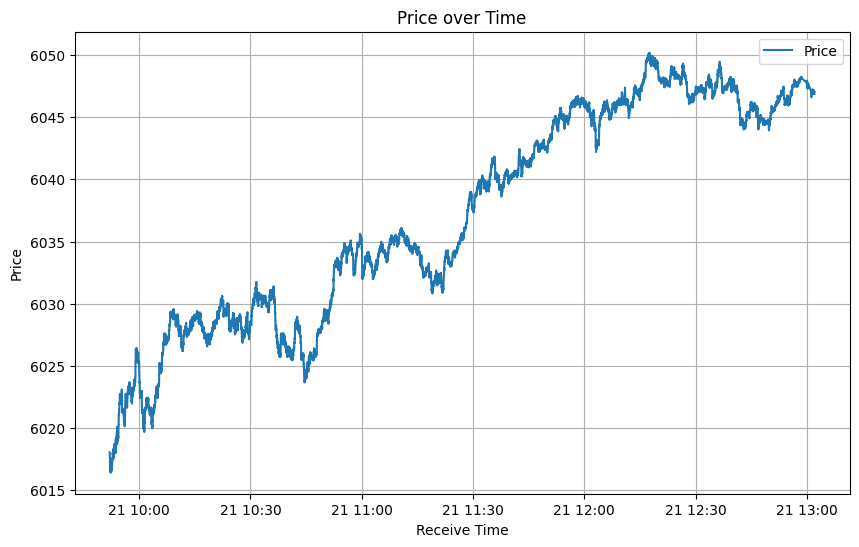

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(spx_df['recv_time'], spx_df['price'], label='Price')
plt.xlabel('Receive Time')
plt.ylabel('Price')         
plt.title('Price over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
spx_df['hour'] = spx_df['recv_time'].dt.hour
spx_df['minute'] = spx_df['recv_time'].dt.minute
spx_df['second'] = spx_df['recv_time'].dt.second
spx_df['microsecond'] = spx_df['recv_time'].dt.microsecond

print(spx_df.head())

In [ ]:
print(spx_df.head(100))
spx_df.to_csv('spx_data.csv', index=False)

In [ ]:
cur.execute("SELECT recv_time, price, name FROM spx_price_all_yesterday;")
spx_all_data = cur.fetchall()

spx_all_df = pd.DataFrame(spx_all_data, columns=['recv_time', 'price', 'name'])
spx_all_df.sort_values(by='recv_time', inplace=True)
spx_all_df['price'] = spx_all_df['price'].astype(float)

spx_all_df['hour'] = spx_all_df['recv_time'].dt.hour
spx_all_df['minute'] = spx_all_df['recv_time'].dt.minute
spx_all_df['second'] = spx_all_df['recv_time'].dt.second
spx_all_df['microsecond'] = spx_all_df['recv_time'].dt.microsecond

print(spx_all_df.head())

spx_all_df.to_csv('spx_all_data.csv', index=False)

